# Адаптивный линейный предсказатель
Идея адаптивного линейного предсказателя (Adaptive Line Enhancer (ALE)) заключается в попытке применить адаптивный фильтр для предсказания будущих значений сигнала, опираясь на предыдущие значения.

Предсказать можно только такие сигналы, в которых есть взаимосвязи между предыдущими отсчетами. Например, периодические сигналы. Если вы знаете, что сигнал периодический, и можете один период его записать, то легко предскажете значения в любой другой момент времени.

Если зависимости между отсчетами меняются во времени, то нужен адаптивный фильтр, который бы подстраивался под изменение зависимостей. Фактически такой фильтр пытается предсказать тот же сигнал, что поступал ему на вход, но с задержкой.    

Такой фильтр можно использовать для очистки речи от **квази периодических** помех. Предполагаем, что сигнал речи достаточно случаен и непереодический, а, значит, его не предсказать. Тогда предсказываем только помехи. Вычтя из зашумленного сигнала предсказанную помеху, получим очищенный сигнал, как на рисунке.   

![img](https://www.advsolned.com/wp-content/uploads/2018/07/LMS_predictor.jpg)

# Библиотека padasip
Для работы с **адаптивными фильтрами** подходит библиотека [padasip (Python Adaptive Signal Processing)](http://matousc89.github.io/padasip/index.html) в которой реализовано множество адаптивных фильтров, в том числе фильтр LMS и его модификации.



In [1]:
# установим библиотеку
!pip install padasip

  Preparing metadata (setup.py) ... done
  Created wheel for padasip: filename=padasip-1.2.2-py3-none-any.whl size=51651 sha256=1e3886ac2832e09d7ba4869b0fe4be7965fbb2995e057d97c76e4cf759728fc4
  Stored in directory: /root/.cache/pip/wheels/a0/bb/e7/b57f417dbad7d85dbcb177f2c185543ca34a1b36541f115e95
Successfully built padasip


In [2]:
# загрузим пример речи
!wget https://github.com/matousc89/Python-Adaptive-Signal-Processing-Handbook/raw/master/notebooks/ALE/Frase_de_Neil_Armstrong.wav

--2023-12-20 15:20:44--  https://github.com/matousc89/Python-Adaptive-Signal-Processing-Handbook/raw/master/notebooks/ALE/Frase_de_Neil_Armstrong.wav
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/matousc89/Python-Adaptive-Signal-Processing-Handbook/master/notebooks/ALE/Frase_de_Neil_Armstrong.wav [following]
--2023-12-20 15:20:45--  https://raw.githubusercontent.com/matousc89/Python-Adaptive-Signal-Processing-Handbook/master/notebooks/ALE/Frase_de_Neil_Armstrong.wav
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1359626 (1.3M) [audio/wav]
Saving to: ‘Frase_de_Neil_Armstrong.wav’

Frase_de_Nei

## Загрузка данных и предподготовка
Звуковые данные загружаются как массив numpy командой `scipy.io.wavfile.read`. Оставляем только один звуковой канал (считаем, что другие, если есть, содержат тот же звук) и масштабируем отсчеты нормализуя их (нулевое среднее, единичный разброс) и деля на 10.

In [3]:
import matplotlib.pylab as plt # рисование
import padasip as pa # адаптивные фильтры
import numpy as np # массивы
from scipy.io import wavfile # звуковые файлы
from scipy.fftpack import fft # преобразование Фурье
from IPython.display import Audio # воспроизведение
import IPython

In [4]:
# Константы
FILENAME = "Frase_de_Neil_Armstrong.wav" # имя файла
SAMPLERATE = 44100 # частота дискретизации
n = 300 # размер фильтра
D = 200 # задержка фильтра

In [5]:
# Функция для нормализации
def zs(a):
    """ 1d data z-score """
    a -= a.mean() # вычитаем среднее
    return a / a.std() # делим на разброс

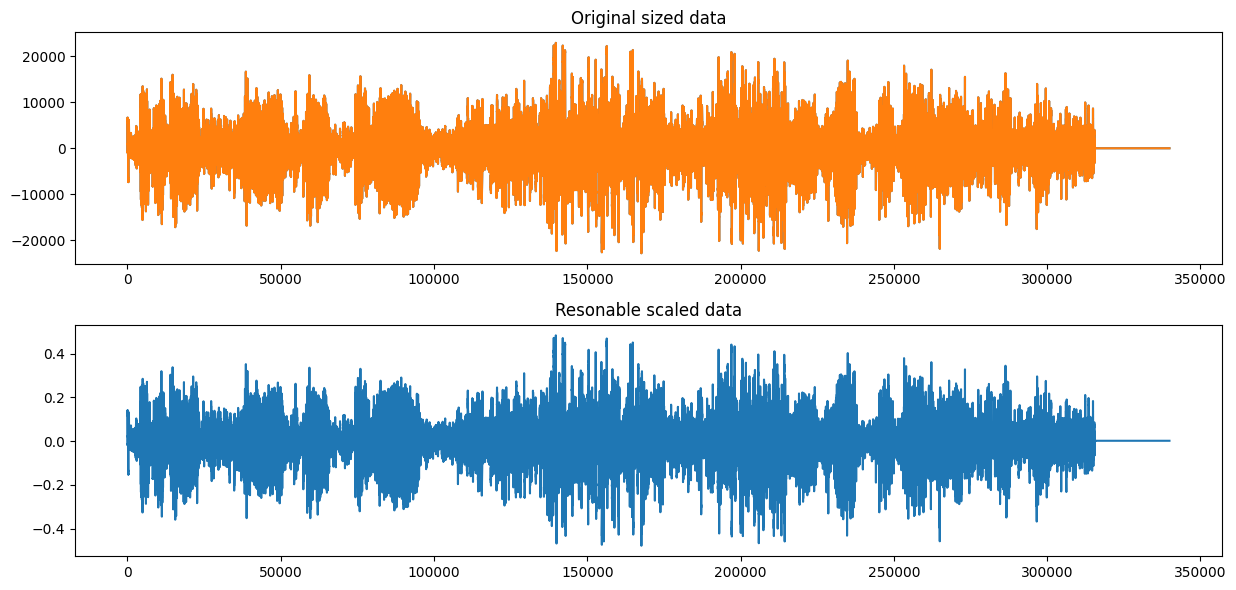

In [6]:
fs, data = wavfile.read(FILENAME) # загружаем файл
y = data[:,0].copy() # оставляем канал 0, копируем
y = y.astype("float64") #  в тип чисел с плавающей точкой.
y = zs(y) / 10 # нормализуем
N = len(y) # число отсчетов сигнала
# рисуем
plt.figure(figsize=(12.5,6))

plt.subplot(211)
plt.plot(data)
plt.title("Original sized data")

plt.subplot(212)
plt.plot(y)
plt.title("Resonable scaled data")

plt.tight_layout()
plt.show()

## Повреждение сигнала

Простая периодическая синусообразная помеха была бы слишком простой для фильтрации. Мы используем более сложную помеху, когда гармонический сигнал модулируется другим гармоническим сигналом.

$ A*sin(w*t+B*sin(v*t+c)+d)$

In [7]:
# Помеха
q = np.sin(2*np.pi*1000/99*np.arange(N) + 10.1 * np.sin(2*np.pi/110*np.arange(N)))
d = y + q # сигнал с помехой


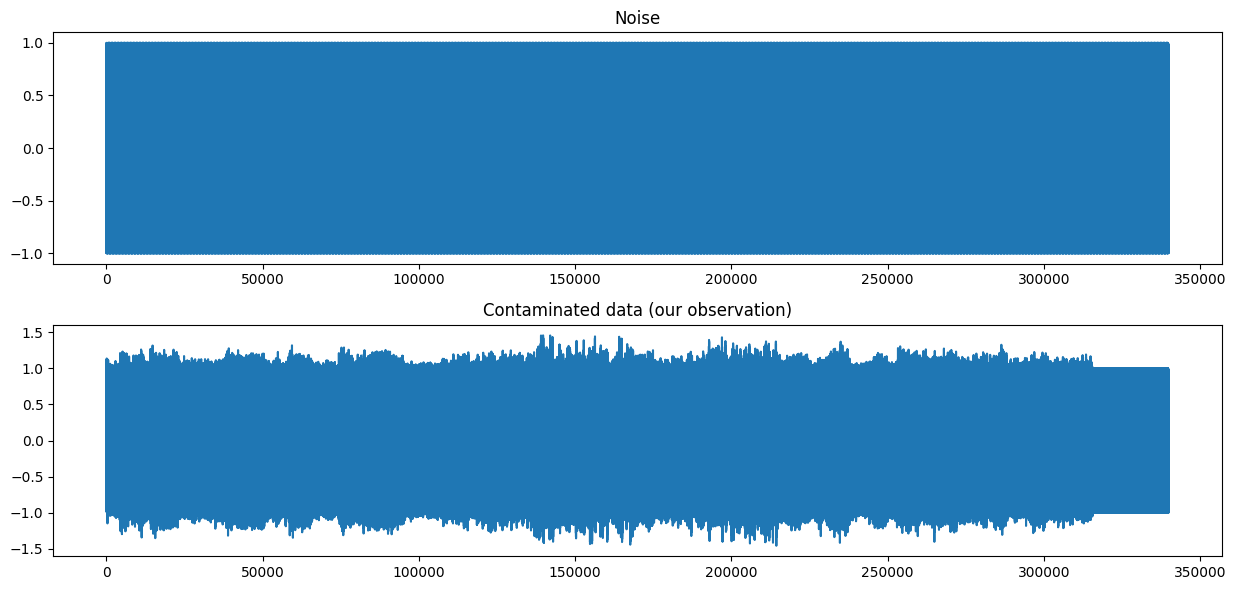

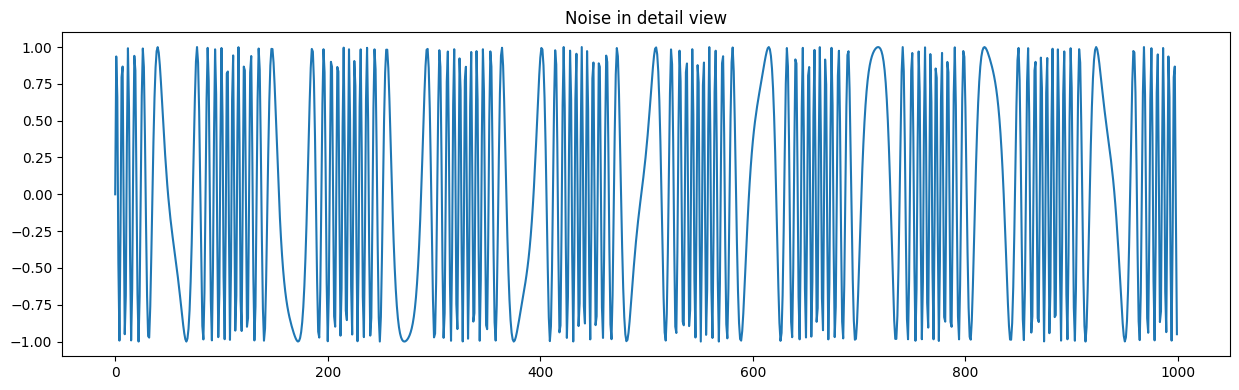

In [8]:
plt.figure(figsize=(12.5,6))
plt.subplot(211)
plt.plot(q)
plt.title("Noise")
plt.subplot(212)
plt.plot(d)
plt.title("Contaminated data (our observation)")
plt.tight_layout()
plt.show()
scope = 1000
plt.figure(figsize=(12.5,4))
plt.plot(q[:scope])
plt.title("Noise in detail view")
plt.tight_layout()
plt.show()

### Характеристики помехи
Чтобы понять, что такая **частотно-модулированная** помеха не банальна, давайте посмотрим на ее спектр.

In [9]:
# Расчет и построение спектра
def fft_helper(qf, label=""):
    """ FFT helper function """
    Nf = len(qf) # длина сигнала
    T = 1.0 / SAMPLERATE # длительность отсчета
    yf = fft(qf) # преобразование Фурье (быстрое)
    # Спектр симметричен, рисуем только половину
    # Вообще, коэффициенты комплексные, рисуем только их модуль
    xf = np.linspace(0.0, 1.0/(2.0*T), Nf//2) # частоты (условно)

    plt.figure(figsize=(12.5,6))

    plt.subplot(211)
    plt.plot(qf)
    plt.title(label)
    plt.ylabel("Amplitude [-]")
    plt.xlabel("Sample index [sample]")

    plt.subplot(212)
    plt.plot(xf, 2.0/Nf * np.abs(yf[0:Nf//2])) # спектр
    plt.title("Frequency spectrum")
    plt.ylabel("Power [-]")
    plt.xlabel("Freq [Hz]")

    plt.tight_layout()
    plt.show()

Nf = 1000

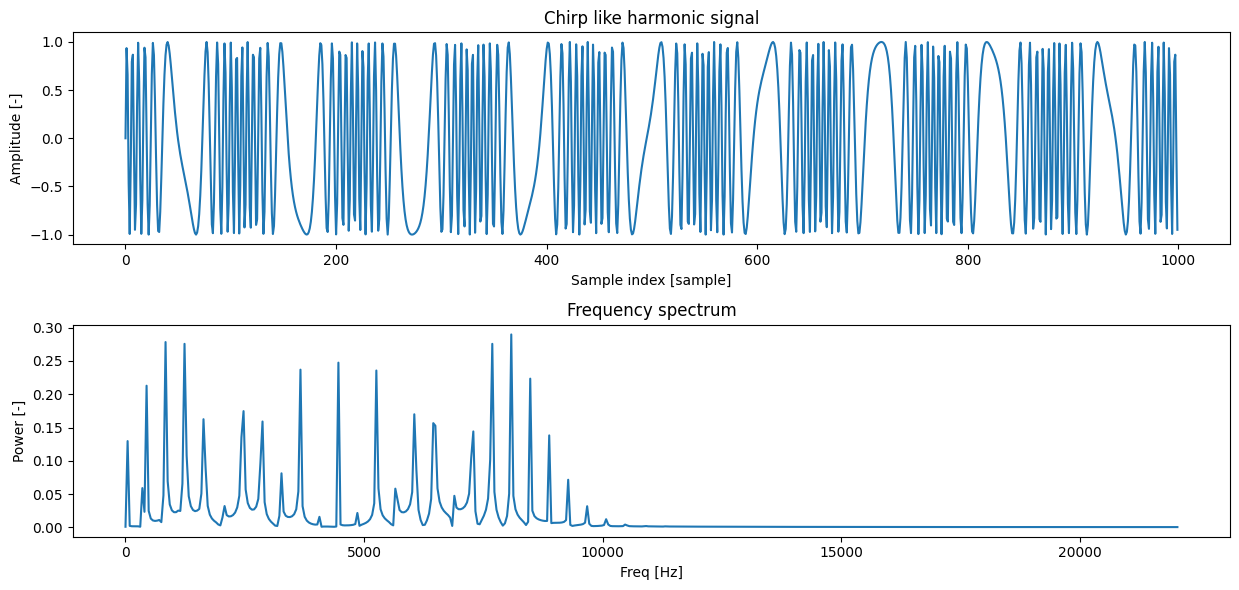

In [ ]:
qf1 = np.sin(2*np.pi*1000/99*np.arange(Nf) + 10.1 * np.sin(2*np.pi/110*np.arange(Nf)))
fft_helper(qf1, label="Chirp like harmonic signal")

Спектр довольно сложный, помеха присутствует на разных частотах.

Для гармонической помехи все было бы просто:

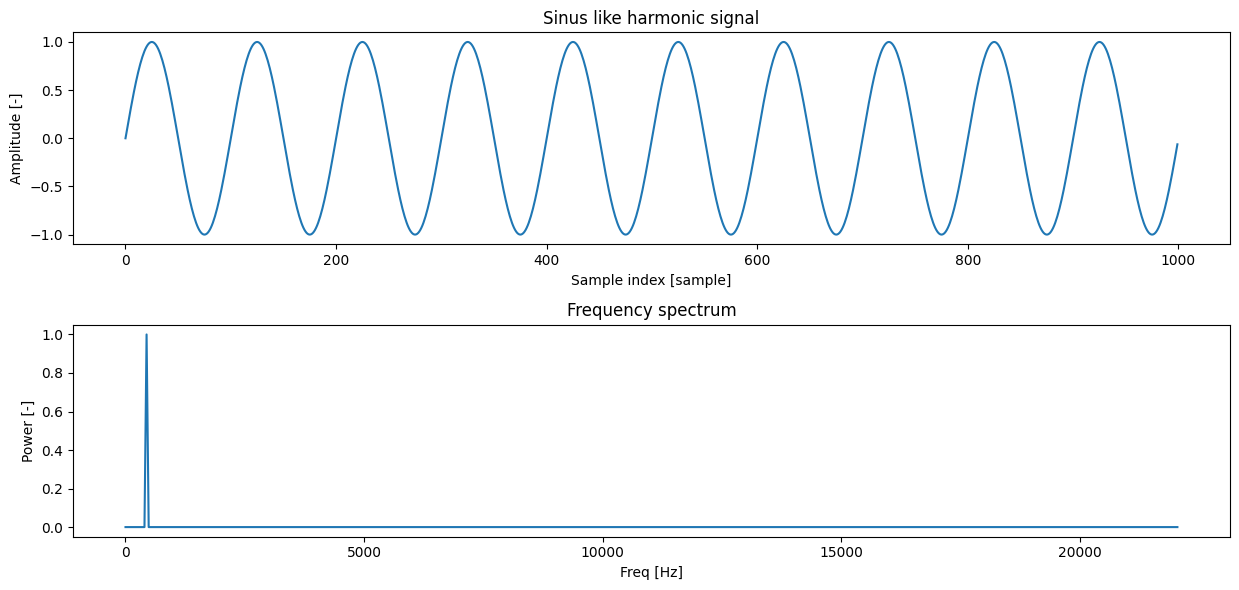

In [10]:
qf2 = np.sin(2*np.pi*0.01*np.arange(Nf))
fft_helper(qf2, label="Sinus like harmonic signal")

Спектр речи без помехи:

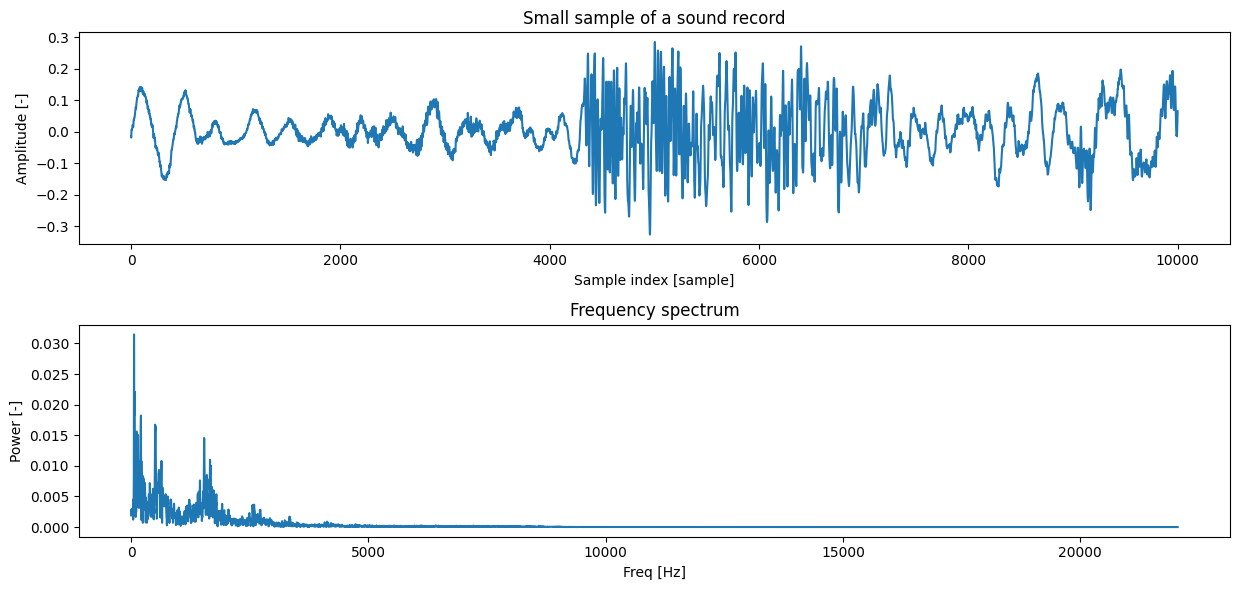

In [11]:
fft_helper(y[:10000], label="Small sample of a sound record")

Спектр речи с помехой:

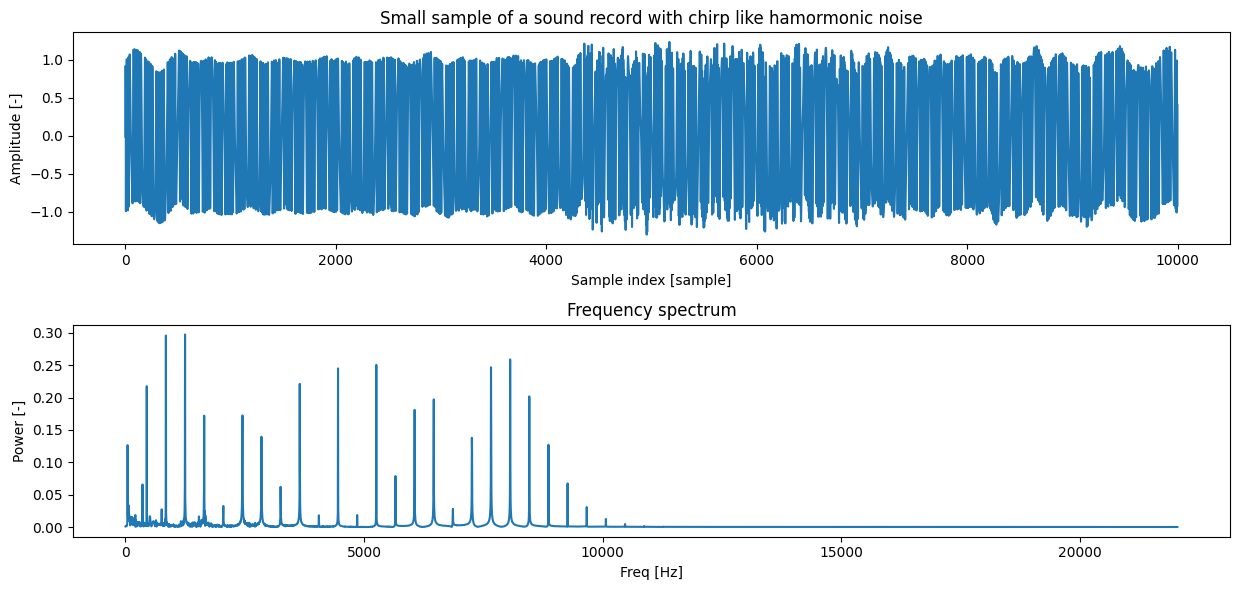

In [12]:
Nf = 10000
qf1l = np.sin(2*np.pi*1000/99*np.arange(Nf) + 10.1 * np.sin(2*np.pi/110*np.arange(Nf)))
fft_helper(y[:Nf] + qf1l, label="Small sample of a sound record with chirp like hamormonic noise")

## Создание адаптивного фильтра и фильтрация
Данные для фильтра нужно представить в требуемом формате.
Каждый элемент в примерах входа (строка в `x`) должен быть вектором **предыдущих** (задержанных) значений шумного сигнала (`d`), которые сопоставляются текущим значениям этого же сигнала.

In [13]:
x = pa.input_from_history(d, n)[:-D]
d = d[n+D-1:]
y = y[n+D-1:]
q = q[n+D-1:]

In [14]:
print(x[0,0:5])
print(x[1,0:5])
print(x[2,0:5])
print()
print(d[0:2])
print(x[D:D+2,-1])

[-0.01531698  0.91780219  0.65154668 -0.46833838 -0.9896969 ]
[ 0.91780219  0.65154668 -0.46833838 -0.9896969  -0.25460976]
[ 0.65154668 -0.46833838 -0.9896969  -0.25460976  0.80067438]

[0.35818086 0.43505154]
[0.35818086 0.43505154]


Создаем фильтр, например **нормализованный LMS** (NLMS), команда [`padasip.filters.FilterNLMS`](https://matousc89.github.io/padasip/sources/filters/nlms.html). Указываем длину фильтра (число коэффициентов) `n`, шаг обучения `mu` и начальные значения для весов фильтра `w`.

В своих экспериментах реализуйте и другие модификации LMS фильтра.

In [15]:
f = pa.filters.FilterNLMS(n=n, mu=0.01, w="zeros") # создаем фильтр


Обучение , и одновременно расчет, фильтра выполняется командой `run()`, указываем желаемый выходной сигнал и входной сигнал.  

In [16]:
yp, e, w = f.run(d, x) # фильтруем, d - желаемый сигнал, x - входной сигнал

Возвращается отфильтрованный сигнал (выход фильтра), ошибка фильтрации `e` (разница желаемого и действительного выхода) и история весов фильтра.

Сигнал ошибки `e` в нашей схеме и есть очищенный сигнал.

In [17]:
# Воспроизведение
print("Original record:")
IPython.display.display(Audio(y, rate=SAMPLERATE))

# Осторожно - громкий неприятный шум
print("Distorted record:")
IPython.display.display(Audio(d, rate=SAMPLERATE))

print("Enhanced record")
IPython.display.display(Audio(e, rate=SAMPLERATE))

Output hidden; open in https://colab.research.google.com to view.

In [18]:
# Сохранение
wavfile.write("orig.wav", 44100, d)
wavfile.write("distorted.wav", 44100, d)
wavfile.write("enhanced.wav", 44100, e)

## Эксперименты
Проверьте работу схемы шумоподавления при разных параметрах:
- тип фильтра
- длина фильтра (число коэффициентов)
- задержка фильтра
- шаг обучения



Изучите другие фильтры и команды padasip. Обязательны для изучения фильтры:
- Least-mean-square (LMS)
- Normalized Least-mean-square (NLMS)
- Sign-sign Least-mean-square (SSLMS)
- Normalized Sign-sign Least-mean-square (NSSLMS)
- Generalized Normalized Gradient Descent (GNGD)
- и общая форма [Adaptive Filters](https://matousc89.github.io/padasip/sources/filters.html)

# Адаптация в реальном времени
В предыдущем примере сигналы уже были записаны в память компьютера, т.е. были измерены.

Адаптивные фильтры могут обучаться в реальном времени, после получения каждого из примеров.

Для этого создадим генераторы данных, функции который будут возвращать текущие отсчеты сигналов.

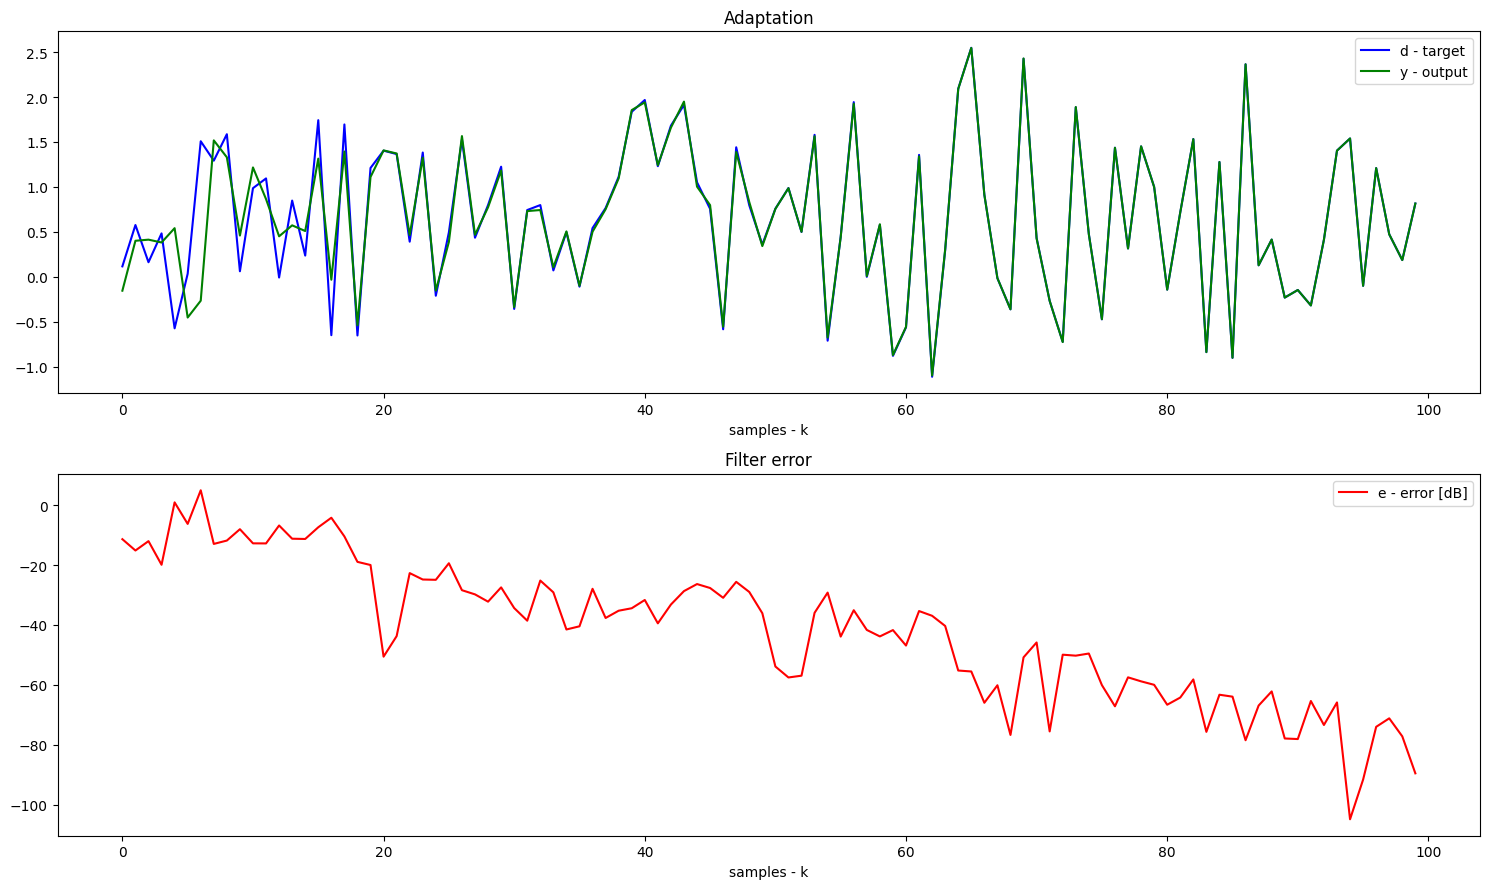

In [ ]:
import numpy as np
import matplotlib.pylab as plt
import padasip as pa

# генератор входов
def measure_x():
    # возвращает вектор длины 3
    x = np.random.random(3)
    return x

# генератор желаемых выходов
def measure_d(x):
    # принимает текущий вход
    # возвращает текущий выход
    d = 2*x[0] + 1*x[1] - 1.5*x[2]
    return d

N = 100 # длина сигнала
log_d = np.zeros(N) # хранилище истории желаемого выходного сигнала
log_y = np.zeros(N) # хранилище истории выходного сигнала
filt = pa.filters.FilterLMS(3, mu=1.) # создаем фильтр
# Цикл по времени
for k in range(N):
    # "измеряем" вход
    x = measure_x()
    # считаем выход фильтра с текущими значениями весов
    y = filt.predict(x)
    # что-то делаем с выходом
    pass
    # "измеряем" желаемый выход
    d = measure_d(x)
    # адаптируем фильтр
    filt.adapt(d, x) # желаемый сигнал, сигнал входа
    # сохраняем историю
    log_d[k] = d
    log_y[k] = y

### рисуем
plt.figure(figsize=(15,9))
plt.subplot(211);plt.title("Adaptation");plt.xlabel("samples - k")
plt.plot(log_d,"b", label="d - target")
plt.plot(log_y,"g", label="y - output");plt.legend()
plt.subplot(212);plt.title("Filter error");plt.xlabel("samples - k")
plt.plot(10*np.log10((log_d-log_y)**2),"r", label="e - error [dB]")
plt.legend(); plt.tight_layout(); plt.show()

# Ссылки
Использованы и адаптированы материалы
- https://matousc89.github.io/padasip/sources/filters.html
- https://github.com/matousc89/padasip
